# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>
## <center>Trabajo Práctico 2 : Críticas Cinematográficas </center>
#### Grupo 29:
* Alen Davies Leccese - 107084
* Luca Lazcano - 107044

## Imports y carga de datos

In [331]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb
from xgboost import XGBClassifier
import pickle
import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

from collections import Counter
from statistics import mean

RANDOM_STATE = 42

Cargamos los datasets a utilizar.

In [332]:
train = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')

Vemos la forma del dataset de entrenamiento:

In [333]:
shape = train.shape
print("Filas: %d Columnas: %d" % (shape[0], shape[1]))

Filas: 50000 Columnas: 3


Y algunas filas del mismo:

In [334]:
train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Preprocesamiento

Comenzamos por convertir a tipo str y a minúscula la columna ``'review_es'`` que es la que contiene las críticas.

In [335]:
test['review_es'] = test['review_es'].astype(str).str.lower()
train['review_es'] = train['review_es'].astype(str).str.lower()
train.head()

,ID,review_es,sentimiento
0,0,uno de los otros críticos ha mencionado que de...,positivo
1,1,una pequeña pequeña producción.la técnica de f...,positivo
2,2,pensé que esta era una manera maravillosa de p...,positivo
3,3,"básicamente, hay una familia donde un niño peq...",negativo
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo


### Tokenización de las reviews

Usamos RegexpTokenizer de nltk para splitear las reviews en palabras. Usamos la expresión regular ``\w+`` que coincide con una o más letras, números o guiones bajos.

In [336]:
regexp = RegexpTokenizer('\w+')

test['review_token'] = test['review_es'].apply(regexp.tokenize)
train['review_token'] = train['review_es'].apply(regexp.tokenize)
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[uno, de, los, otros, críticos, ha, mencionado..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[una, pequeña, pequeña, producción, la, técnic..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, que, esta, era, una, manera, maravillo..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, hay, una, familia, donde, un, ni..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[el, amor, en, el, tiempo, de, petter, mattei,..."


### Eliminar Stopwords

Las stopwords (palabras vacías), son palabras muy comunes en un idioma que generalmente no aportan un significado importante al análisis de texto.

Incluyen palabras como artículos ("el", "la", "los", "las"), pronombres ("yo", "tú", "él", "ella"), preposiciones ("a", "de", "en", "con").

Se eliminan para reducir el ruido y el tamaño del vocabulario en el texto analizado, centrándose en las palabras clave. Al hacer esto, se puede mejorar el rendimiento de algoritmos de procesamiento de texto.

Procedemos a descargar el paquete de stopwords de nltk.

In [337]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Obtenemos las stopwords en español y las almacenamos en una variable.

In [338]:
stopwords_es = nltk.corpus.stopwords.words("spanish")
print(stopwords_es)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

Y ahora las eliminamos de las reviews.

In [339]:
test['review_token'] = test['review_token'].apply(lambda x: [item for item in x if item not in stopwords_es])
train['review_token'] = train['review_token'].apply(lambda x: [item for item in x if item not in stopwords_es])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, ver, solo, 1, ..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, fi..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua..."


Hacemos lo mismo con las stopwords en inglés. Las reviews están en español pero puede haber palabras en inglés asociadas a nombres propios o títulos de películas.

In [340]:
stopwords_en = nltk.corpus.stopwords.words("english")
print(stopwords_en)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [341]:
test['review_token'] = test['review_token'].apply(lambda x: [item for item in x if item not in stopwords_en])
train['review_token'] = train['review_token'].apply(lambda x: [item for item in x if item not in stopwords_en])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, ver, solo, 1, ..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, fi..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua..."


### Filtrar por largo de las palabras

Ahora vamos a eliminar las palabras que contengan menos de 3 letras, ya que éstas suelen ser conectores o artículos que no aportan información relevante.

In [342]:
test['review_token'] = test['review_token'].apply(lambda x: [item for item in x if len(item) > 3])
train['review_token'] = train['review_token'].apply(lambda x: [item for item in x if len(item) > 3])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, solo, episodio..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, se..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua..."


### Igualar palabras con o sin tilde

Pudimos observar que algunas palabras estaban duplicadas ya que algunas tenian tilde y otras no. Por ejemplo, "pelicula" y "película". Para evitar esto, vamos a reemplazar las vocales con tilde por las mismas sin tilde.

In [343]:
def remove_tildes(text):
    tildes = {
        'á': 'a',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u'
    }
    for key, value in tildes.items():
        text = text.replace(key, value)
    return text

In [344]:
test['review_token'] = test['review_token'].apply(lambda x: [remove_tildes(item) for item in x])
train['review_token'] = train['review_token'].apply(lambda x: [remove_tildes(item) for item in x])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[criticos, mencionado, despues, solo, episodio..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, produccion, tecnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pense, manera, maravillosa, pasar, tiempo, se..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[basicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, pelicula, visua..."


### Filtrar palabras por frecuencia

Vamos a crear una variable que contenga todas las palabras de las reviews.

In [345]:
vocabulario = Counter()

for review in train['review_token']:
    for palabra in review:
        vocabulario[palabra] += 1


In [346]:
len(vocabulario)

168294

Vamos a conservar solo las 10000 palabras más frecuentes y descartar las demás.

In [347]:
vocab_size = 10000
vocabulario_truncado = [ word for word, count in vocabulario.most_common()[:vocab_size] ]

In [348]:
len(vocabulario_truncado)

10000

Podemos ver las 20 palabras más frecuentes en el siguiente gráfico:

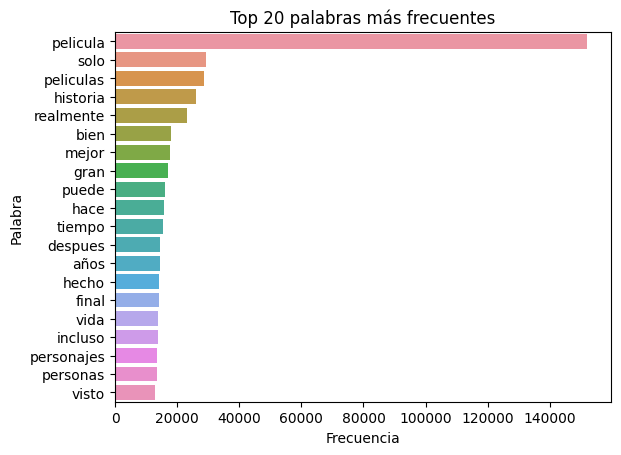

In [349]:
top20 = pd.Series(dict(vocabulario.most_common(20)))
sns.barplot(y=top20.index, x=top20.values).set(title='Top 20 palabras más frecuentes', xlabel='Frecuencia', ylabel='Palabra')

plt.show()

Ahora procedemos a dejar solo las palabras que se encuentran entre las 10000 más frecuentes.

In [350]:
test['review_filtrado'] = test['review_token'].apply(lambda x: [item for item in x if item in vocabulario_truncado])
train['review_filtrado'] = train['review_token'].apply(lambda x: [item for item in x if item in vocabulario_truncado])
train.head()

,ID,review_es,sentimiento,review_token,review_filtrado
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[criticos, mencionado, despues, solo, episodio...","[criticos, mencionado, despues, solo, episodio..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, produccion, tecnica, filmac...","[pequeña, pequeña, produccion, tecnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pense, manera, maravillosa, pasar, tiempo, se...","[pense, manera, maravillosa, pasar, tiempo, se..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[basicamente, familia, niño, pequeño, jake, pi...","[basicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, pelicula, visua...","[amor, tiempo, pelicula, visualmente, impresio..."


### Truncar reviews

Vamos a dejar solo las 300 primeras palabras de cada review, para acortarlas.

In [351]:
test['review_filtrado_300'] = test['review_filtrado'].apply(lambda x: x[:300])
train['review_filtrado_300'] = train['review_filtrado'].apply(lambda x: x[:300])
train.head()

,ID,review_es,sentimiento,review_token,review_filtrado,review_filtrado_300
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[criticos, mencionado, despues, solo, episodio...","[criticos, mencionado, despues, solo, episodio...","[criticos, mencionado, despues, solo, episodio..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, produccion, tecnica, filmac...","[pequeña, pequeña, produccion, tecnica, filmac...","[pequeña, pequeña, produccion, tecnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pense, manera, maravillosa, pasar, tiempo, se...","[pense, manera, maravillosa, pasar, tiempo, se...","[pense, manera, maravillosa, pasar, tiempo, se..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[basicamente, familia, niño, pequeño, jake, pi...","[basicamente, familia, niño, pequeño, jake, pi...","[basicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, pelicula, visua...","[amor, tiempo, pelicula, visualmente, impresio...","[amor, tiempo, pelicula, visualmente, impresio..."


### Unión de las palabras en strings

Juntamos las palabras de todas las reviews para que vuelvan a ser un string.

In [352]:
test['review_filtrado_string'] = test['review_filtrado_300'].apply(lambda x: ' '.join(x))
train['review_filtrado_string'] = train['review_filtrado_300'].apply(lambda x: ' '.join(x))
train.head()

,ID,review_es,sentimiento,review_token,review_filtrado,review_filtrado_300,review_filtrado_string
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[criticos, mencionado, despues, solo, episodio...","[criticos, mencionado, despues, solo, episodio...","[criticos, mencionado, despues, solo, episodio...",criticos mencionado despues solo episodio enga...
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, produccion, tecnica, filmac...","[pequeña, pequeña, produccion, tecnica, filmac...","[pequeña, pequeña, produccion, tecnica, filmac...",pequeña pequeña produccion tecnica filmacion a...
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pense, manera, maravillosa, pasar, tiempo, se...","[pense, manera, maravillosa, pasar, tiempo, se...","[pense, manera, maravillosa, pasar, tiempo, se...",pense manera maravillosa pasar tiempo semana v...
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[basicamente, familia, niño, pequeño, jake, pi...","[basicamente, familia, niño, pequeño, jake, pi...","[basicamente, familia, niño, pequeño, jake, pi...",basicamente familia niño pequeño jake piensa z...
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, pelicula, visua...","[amor, tiempo, pelicula, visualmente, impresio...","[amor, tiempo, pelicula, visualmente, impresio...",amor tiempo pelicula visualmente impresionante...


### Bag of Words

La técnica Bag of Words es una forma de representar datos de texto en aprendizaje automático. El concepto básico es tratar cada documento de texto como una "bolsa" de palabras, donde se ignora el orden y la estructura gramatical de las palabras. En lugar de eso, se enfoca únicamente en la presencia y frecuencia de las palabras en el texto.

Vamos a utilizar ``TfidfVectorizer`` de scikit-learn que implementa la técnica de ponderación TF-IDF (Term Frequency-Inverse Document Frequency) para convertir datos de texto en características numéricas.

In [353]:
vectorizer = TfidfVectorizer()
train_fid = vectorizer.fit_transform(train.review_filtrado_string)
test_fid = vectorizer.transform(test.review_filtrado_string)

In [354]:
print(train_fid)

  (0, 6793)	0.07895856355280216
  (0, 5458)	0.0614521065749212
  (0, 2121)	0.0957988678733533
  (0, 7630)	0.05916120808205655
  (0, 9813)	0.09059946962097332
  (0, 4949)	0.09514568292128175
  (0, 1911)	0.11160465578791753
  (0, 8538)	0.09419271756567639
  (0, 7628)	0.03923741692650343
  (0, 9745)	0.06709350492991467
  (0, 3806)	0.07075567801600022
  (0, 4530)	0.08677248602244989
  (0, 3925)	0.0662566795715937
  (0, 2541)	0.060437456577177515
  (0, 2193)	0.10606132799322633
  (0, 6035)	0.07304564508415505
  (0, 1749)	0.07070850674913352
  (0, 5884)	0.04615034355496539
  (0, 6761)	0.0934842094457536
  (0, 4488)	0.11545187845691489
  (0, 5045)	0.11858166086046516
  (0, 8717)	0.05807295214419874
  (0, 4426)	0.10727937759000064
  (0, 6520)	0.0901545491867353
  (0, 432)	0.09484966129558828
  :	:
  (49999, 9413)	0.08651695551162088
  (49999, 2069)	0.16774689261842027
  (49999, 9701)	0.10049870175086295
  (49999, 7019)	0.09451293552296919
  (49999, 4115)	0.09158906313691571
  (49999, 3613)	0.1

## Split train/test

Dvidimos el dataset en train y test.

In [393]:
x_train, x_test, y_train, y_test = train_test_split(train_fid,
                                                    train.sentimiento, 
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE, shuffle=True)

Mapeamos las etiquetas de los targets a 0 y 1 para no tener inconvenientes con los modelos.

In [ ]:
label_map = {'negativo': 0, 'positivo': 1}
y_train_mapped = y_train.map(label_map)
y_test_mapped = y_test.map(label_map)
y_train_mapped.head()

38094    0
40624    1
49425    0
35734    1
41708    0
Name: sentimiento, dtype: int64

## Bayes Naive

### Random Search

Realizamos optimización de hiperparámetros con Random Search.

In [417]:
#Cantidad de combinaciones que quiero probar
n=15

#Grilla de Parámetros a probar
params_grid={ 'alpha': [0.5, 1.0, 2.0, 5.0],
               'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4]],
               'fit_prior': [True, False],
               'force_alpha': [True, False]
             }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True)

#Clasificador
NB_model = MultinomialNB()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, pos_label=1)

#Random Search Cross Validation
rand_NB = RandomizedSearchCV(estimator = NB_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv=kfoldcv,
                              n_iter = n,
                              random_state = RANDOM_STATE,
                              verbose=2) 

rand_NB.fit(x_train, y_train_mapped)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END alpha=1.0, class_prior=[0.3, 0.7], fit_prior=True, force_alpha=True; total time=   0.0s
[CV] END alpha=1.0, class_prior=[0.3, 0.7], fit_prior=True, force_alpha=True; total time=   0.0s
[CV] END alpha=1.0, class_prior=[0.3, 0.7], fit_prior=True, force_alpha=True; total time=   0.0s
[CV] END alpha=1.0, class_prior=[0.3, 0.7], fit_prior=True, force_alpha=True; total time=   0.0s
[CV] END alpha=1.0, class_prior=[0.3, 0.7], fit_prior=True, force_alpha=True; total time=   0.0s
[CV] END alpha=2.0, class_prior=[0.2, 0.8], fit_prior=True, force_alpha=False; total time=   0.0s
[CV] END alpha=2.0, class_prior=[0.2, 0.8], fit_prior=True, force_alpha=False; total time=   0.0s
[CV] END alpha=2.0, class_prior=[0.2, 0.8], fit_prior=True, force_alpha=False; total time=   0.0s
[CV] END alpha=2.0, class_prior=[0.2, 0.8], fit_prior=True, force_alpha=False; total time=   0.0s
[CV] END alpha=2.0, class_prior=[0.2, 0.8], fit_prior=True, fo

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=MultinomialNB(), n_iter=15,
                   param_distributions={'alpha': [0.5, 1.0, 2.0, 5.0],
                                        'class_prior': [None, [0.1, 0.9],
                                                        [0.2, 0.8], [0.3, 0.7],
                                                        [0.4, 0.6], [0.5, 0.5],
                                                        [0.6, 0.4]],
                                        'fit_prior': [True, False],
                                        'force_alpha': [True, False]},
                   random_state=42, scoring=make_scorer(f1_score, pos_label=1),
                   verbose=2)

Vemos cuales fueron los mejores hiperparámetros y la mejor métrica obtenida.

In [418]:
print('Mejores parámetros: {}'.format(rand_NB.best_params_))
print('Mejor métrica: {}'.format(rand_NB.best_score_))

Mejores parámetros: {'force_alpha': True, 'fit_prior': True, 'class_prior': None, 'alpha': 0.5}
Mejor métrica: 0.8432260543879829


Entrenamos el modelo de Bayes Naive con los mejores hiperparámetros y realizamos las predicciones.

In [419]:
NB_model = MultinomialNB().set_params(**rand_NB.best_params_)
NB_model.fit(x_train, y_train_mapped)

y_pred = NB_model.predict(x_test)

Ahora podemos ver que tan bien le fue a nuestro modelo.

In [420]:
print(f'Best Training Accuracy: {NB_model.score(x_train, y_train_mapped)}')
print(f'Best Testing Accuracy: {NB_model.score(x_test, y_test_mapped)}')

Best Training Accuracy: 0.8660571428571429
Best Testing Accuracy: 0.8439333333333333


### Métricas

Calculamos las métricas de accuracy, precision, recall y f1-score.

In [423]:
accuracy = accuracy_score(y_test_mapped, y_pred)
recall = recall_score(y_test_mapped, y_pred, pos_label=1)
f1 = f1_score(y_test_mapped, y_pred, pos_label=1)
precision = precision_score(y_test_mapped, y_pred, pos_label=1)

print("Accuracy: "  + str(accuracy))
print("Recall: "    + str(recall))
print("Precision: " + str(precision))
print("f1 score: "  + str(f1))

Accuracy: 0.8439333333333333
Recall: 0.8492555013835815
Precision: 0.8433656110965716
f1 score: 0.8463003085811831


Vemos el reporte de clasificación.

In [424]:
print(classification_report(y_test_mapped, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      7411
           1       0.84      0.85      0.85      7589

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Y la matriz de confusion.

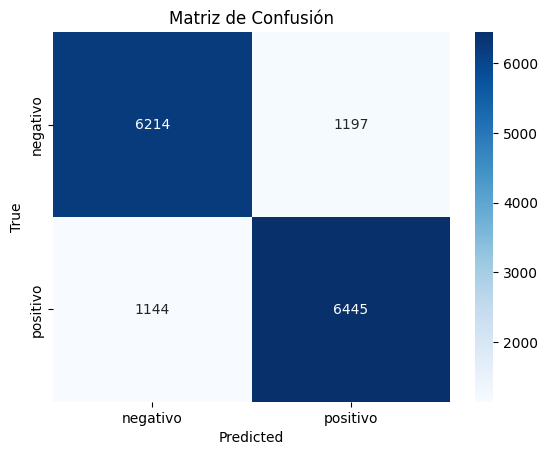

In [425]:
cm = confusion_matrix(y_test_mapped,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

Guardamos el modelo en un archivo .pickle y generamos la submission para kaggle.

In [364]:
pickle.dump(NB_model, open('NB_grupo29.pickle', 'wb'))

In [429]:
X_submission_NB = test_fid
y_pred_test_NB = NB_model.predict(X_submission_NB)

In [432]:
label_map = {0: 'negativo', 1: 'positivo'}
y_pred_test_NB = pd.Series(y_pred_test_NB).map(label_map)

In [434]:
df_submission_NB = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_NB})
df_submission_NB.to_csv('NB04.csv', index=False)

## Random Forest

### Random Search

Optimizamos hiperparámetros con Random Search.

In [373]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_estimators': [100, 200, 300, 400, 500],
                'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40],
                'max_depth': [None],
                'max_samples': [None, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0],
                'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 1.0],
             }

#Clasificador
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_rf = RandomizedSearchCV(estimator = rf_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE,
                              verbose=2,
                              cv=2) 

rand_rf.fit(x_train, y_train)
rand_rf.cv_results_['mean_test_score'] 

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[CV] END ccp_alpha=0.1, max_depth=None, max_samples=0.95, min_samples_split=2, n_estimators=200; total time= 2.6min
[CV] END ccp_alpha=0.1, max_depth=None, max_samples=0.95, min_samples_split=2, n_estimators=200; total time= 2.7min
[CV] END ccp_alpha=1.0, max_depth=None, max_samples=0.95, min_samples_split=15, n_estimators=500; total time= 5.1min
[CV] END ccp_alpha=1.0, max_depth=None, max_samples=0.95, min_samples_split=15, n_estimators=500; total time=10.4min
[CV] END ccp_alpha=0.01, max_depth=None, max_samples=0.99, min_samples_split=5, n_estimators=100; total time= 3.4min
[CV] END ccp_alpha=0.01, max_depth=None, max_samples=0.99, min_samples_split=5, n_estimators=100; total time= 2.5min
[CV] END ccp_alpha=1.0, max_depth=None, max_samples=None, min_samples_split=30, n_estimators=500; total time= 6.0min
[CV] END ccp_alpha=1.0, max_depth=None, max_samples=None, min_samples_split=30, n_estimators=500; total time= 3.7min
[CV] END ccp_alpha=0.1, max_depth=None, max_samples=0.95, min_samp

array([0.        , 0.        , 0.72418879, 0.        , 0.        ])

In [374]:
print('Mejores parámetros: {}'.format(rand_rf.best_params_))
print('Mejor métrica: {}'.format(rand_rf.best_score_))

Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 5, 'max_samples': 0.99, 'max_depth': None, 'ccp_alpha': 0.01}
Mejor métrica: 0.7241887891698224


Entrenamos el modelo con los mejores hiperparámetros y realizamos las predicciones.

In [375]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE).set_params(**rand_rf.best_params_)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Veamos que tan bien le fue a nuestro modelo.

In [376]:
print(f'Best Training Accuracy: {rf_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {rf_model.score(x_test, y_test)}')

Best Training Accuracy: 0.6955142857142858
Best Testing Accuracy: 0.7028666666666666


### Métricas

Calculamos las métricas de accuracy, precision, recall y f1-score.

In [381]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "  + str(accuracy))
print("Recall: "    + str(recall))
print("Precision: " + str(precision))
print("f1 score: "  + str(f1))

Accuracy: 0.7028666666666666
Recall: 0.8115693767294768
Precision: 0.670476812540823
f1 score: 0.7343070044709389


El reporte de clasificación.

In [382]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66      7411
           1       0.67      0.81      0.73      7589

    accuracy                           0.70     15000
   macro avg       0.71      0.70      0.70     15000
weighted avg       0.71      0.70      0.70     15000



Y la matriz de confusion.

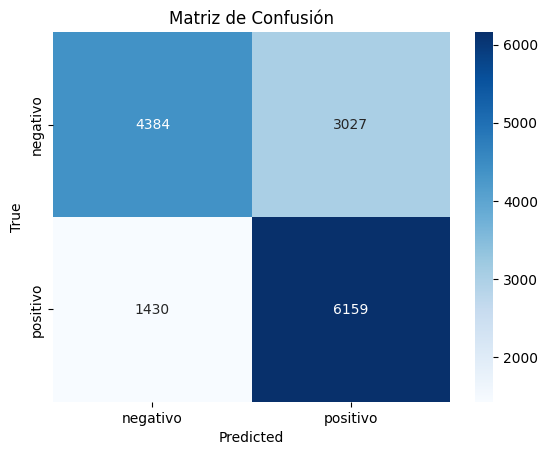

In [383]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

Guardamos el modelo en un archivo .pickle y generamos la submission para kaggle.

In [384]:
pickle.dump(rf_model, open('rf_grupo29.pickle', 'wb'))

In [386]:
X_submission_rf = test_fid
y_pred_test_rf = rf_model.predict(X_submission_rf)

In [388]:
label_map = {0: 'negativo', 1: 'positivo'}
y_pred_test_rf = pd.Series(y_pred_test_rf).map(label_map)

In [389]:
df_submission_rf = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_rf})
df_submission_rf.to_csv('rf01.csv', index=False)

## XGBoost

### Random Search

Optimizamos hiperparámetros con Random Search.

In [395]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid= {'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [0,1,2],
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [1],
                'n_estimators': list(range(10,161,10))
              }

#Clasificador
xgb_model = XGBClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_xgb = RandomizedSearchCV(estimator = xgb_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE,
                              verbose=2) 

rand_xgb.fit(x_train, y_train_mapped)
rand_xgb.cv_results_['mean_test_score'] 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END alpha=1, gamma=0, lambda=0, learning_rate=0.4816326530612245, max_depth=7, n_estimators=20, subsample=0.9473684210526315; total time=  12.0s
[CV] END alpha=1, gamma=0, lambda=0, learning_rate=0.4816326530612245, max_depth=7, n_estimators=20, subsample=0.9473684210526315; total time=  12.7s
[CV] END alpha=1, gamma=0, lambda=0, learning_rate=0.4816326530612245, max_depth=7, n_estimators=20, subsample=0.9473684210526315; total time=  13.7s
[CV] END alpha=1, gamma=0, lambda=0, learning_rate=0.4816326530612245, max_depth=7, n_estimators=20, subsample=0.9473684210526315; total time=  15.2s
[CV] END alpha=1, gamma=0, lambda=0, learning_rate=0.4816326530612245, max_depth=7, n_estimators=20, subsample=0.9473684210526315; total time=  18.5s
[CV] END alpha=1, gamma=1, lambda=2, learning_rate=0.1602040816326531, max_depth=3, n_estimators=60, subsample=0.7894736842105263; total time=  16.3s
[CV] END alpha=1, gamma=1, lambda=2, lea

array([0.79729197, 0.79227801, 0.77605035, 0.78959425, 0.81612308])

In [396]:
print('Mejores parámetros: {}'.format(rand_xgb.best_params_))
print('Mejor métrica: {}'.format(rand_xgb.best_score_))

Mejores parámetros: {'subsample': 0.42105263157894735, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.4448979591836735, 'lambda': 0, 'gamma': 0, 'alpha': 1}
Mejor métrica: 0.8161230789803892


Entrenamos el modelo con los mejores hiperparámetros y realizamos las predicciones.

In [398]:
xgb_model = XGBClassifier(random_state=RANDOM_STATE).set_params(**rand_xgb.best_params_)
xgb_model.fit(x_train, y_train_mapped)

y_pred = xgb_model.predict(x_test)

Veamos que tan bien le fue a nuestro modelo.

In [399]:
print(f'Best Training Accuracy: {xgb_model.score(x_train, y_train_mapped)}')
print(f'Best Testing Accuracy: {xgb_model.score(x_test, y_test_mapped)}')

Best Training Accuracy: 0.8331428571428572
Best Testing Accuracy: 0.8163333333333334


### Métricas

Calculamos las métricas de accuracy, precision, recall y f1-score.

In [400]:
accuracy = accuracy_score(y_test_mapped, y_pred)
recall = recall_score(y_test_mapped, y_pred)
f1 = f1_score(y_test_mapped, y_pred)
precision = precision_score(y_test_mapped, y_pred)

print("Accuracy: "  + str(accuracy))
print("Recall: "    + str(recall))
print("Precision: " + str(precision))
print("f1 score: "  + str(f1))

Accuracy: 0.8163333333333334
Recall: 0.8517591250494136
Precision: 0.7986162589572523
f1 score: 0.8243320793215584


El reporte de clasificación.

In [401]:
print(classification_report(y_test_mapped, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      7411
           1       0.80      0.85      0.82      7589

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



Y la matriz de confusion.

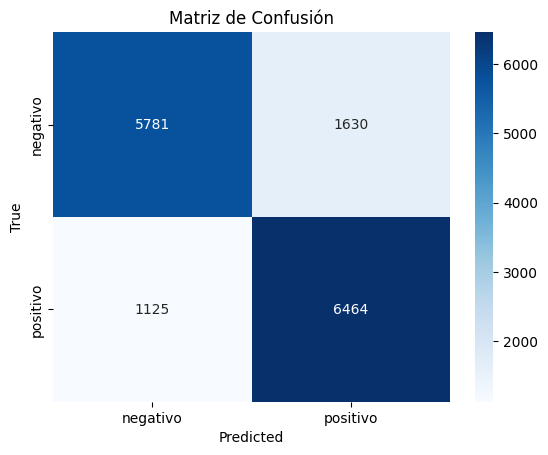

In [402]:
cm = confusion_matrix(y_test_mapped, y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

Guardamos el modelo en un archivo .pickle y generamos la submission para kaggle.

In [403]:
pickle.dump(xgb_model, open('xgb_grupo29.pickle', 'wb'))

In [405]:
X_submission_xgb = test_fid
y_pred_test_xgb = xgb_model.predict(X_submission_xgb)

In [406]:
label_map = {0: 'negativo', 1: 'positivo'}
y_pred_test_xgb = pd.Series(y_pred_test_xgb).map(label_map)

In [407]:
df_submission_xgb = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_xgb})
df_submission_xgb.to_csv('xgb01.csv', index=False)

## Red Neuronal

### Tokenización y preprocesamiento

Debido a que las redes neuronales puede trabajar únicamente con datos numéricos, es necesario convertir de alguna forma las palabras a alguna representación numérica. Para esto, utilizamos la técnica de tokenización, que consiste en asignarle un número a cada palabra del vocabulario. Luego, cada review se representa como una secuencia de números, donde cada número representa una palabra.

Como ya vimos, la cantidad de palabras únicas es muy alta, y entrenar un modelo con tantos parámetros agrega costo computacional. Se puede limitar el "diccionario", o vocabulario conocido de la red a una cantidad más baja de palabras, que representan las más frecuentes. Para ello, a continuación seteamos este parámetro, en 10000, que es un valor que nos pareció razonable, y que no la performance del modelo.

In [290]:
VOCAB_SIZE = 10000

Además, considerando que algunas reviews son extremadamente largas, y leyendo algunas de ellas, concluimos que en general es posible determinar el sentimiento de una review con las primeras pocas cientos de palabras. Seteamos entonces el largo máximo de las reviews en 300 palabras.

In [291]:
REVIEW_MAX_LENGTH = 300

En la etapa de preprocesamiento, además, se eliminaron las stopwords, se igualaron las palabras con y sin acento, y se eliminaron las palabras con menos de 3 letras. Este preprocesamiento había quedado en la columna ```review_token```, el cual aprovecharemos aquí, pero sin la parte de codificación, largo de review y limitación del vocabulario, ya que eso lo hace el tokenizador de Keras. Preferimos mantener esa parte del procesamiento aquí. Por más que parezca redundate, de este modo tenemos un control más fino sobre el preprocesamiento para la red neuronal, y no afectamos los datos de los otros modelos.

Reconstruimos entonces las reviews en forma de strings a partir la columna ```review_token```

In [292]:
test['review_token_string_rnn'] = test['review_token'].apply(lambda x: ' '.join(x))
train['review_token_string_rnn'] = train['review_token'].apply(lambda x: ' '.join(x))
train.head()

,ID,review_es,sentimiento,review_token,review_token_string_rnn
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[criticos, mencionado, despues, solo, episodio...",criticos mencionado despues solo episodio enga...
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, produccion, tecnica, filmac...",pequeña pequeña produccion tecnica filmacion i...
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pense, manera, maravillosa, pasar, tiempo, se...",pense manera maravillosa pasar tiempo semana v...
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[basicamente, familia, niño, pequeño, jake, pi...",basicamente familia niño pequeño jake piensa z...
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, pelicula, visua...",amor tiempo petter mattei pelicula visualmente...


LLegamos entonces a la utilización de ```Tokenizer()```. Esta herramienta de Keras se encarga de tokenizar las reviews. Por defecto, separa los tokens (argumento ```split```) por espacios, los cual es suficiente para reviews en idioma español, donde las palabras están separadas por espacios. También tiene un filtro (argumento ```filters```) que elimna los signos de puntuación y otros símbolos que no aportan demasiado a la interpretación de una review.

El otro argumento importante, es el argumento ```oov_token```. "OOV" significa "Out Of Vocabulary", y se refiere a las palabras que no están en el vocabulario (recordemos que limitamos el largo del vocabulario, pero aún así, podemos tener en cuenta palabras poco frecuentes con los "buckets" de palabras fuera del vocabulario). Estos buckets agrupan las palabras poco comunes en "buckets" de palabras relacionadas. El tokenizador se encarga de llenar estos "buckets". En general, para estimar la cantidad de buckets, se utiliza un número en el rango del 2% al 5% del tamaño del vocabulario.

In [293]:
OOV_BUCKETS_FACTOR = 0.02
OOV_BUCKETS = int(VOCAB_SIZE * OOV_BUCKETS_FACTOR)

Luego, se encarga de codificar cada review como una secuencia de números, donde cada número representa una palabra del vocabulario. Para esto, se utiliza el método ```fit_on_texts()```, que recibe como parámetro una lista de reviews, y crea el vocabulario a partir de ellas. Luego, se utiliza el método ```texts_to_sequences()```, que recibe como parámetro una lista de reviews, y devuelve una lista de listas, donde cada lista representa una review, y cada número de la lista representa una palabra.

Creamos entonces el tokenizador con los parámetros establecidos.

In [294]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token=f'<OOV>')

Lo fiteamos con las reviews previamente procesadas.

In [295]:
tokenizer.fit_on_texts(train['review_token_string_rnn'])

Podemos ver la cantidad de palabras únicas que encontró el tokenizador. Se deduce que la inmensa mayoría de las palabras quedarán fuera del vocabulario.

In [296]:
print(len(tokenizer.word_index))

168177


Convertimos la columna deseada a un array de numpy, para ser interpretado por los métodos de Keras.

In [297]:
reviews_lista_train = pd.Series(train['review_token_string_rnn']).to_numpy()
reviews_lista_test = pd.Series(test['review_token_string_rnn']).to_numpy()

In [298]:
print(reviews_lista_train[:3])

['criticos mencionado despues solo episodio enganchado razon exactamente sucedio conmigo primera cosa golpeo brutalidad escenas violencia inconfiadas encuentran derecha palabra confia espectaculo debiles corazon timido espectaculo extrae punzones respecto drogas sexo violencia hardcore clasico palabra llama apodo dado penitenciario seguridad maximo oswald centra principalmente ciudad emeralda seccion experimental prision todas celulas frentes vidrio enfrentan hacia adentro privacidad alta agenda city hogar fariarios musulmanes gangstas latinos cristianos italianos irlandeses esposas miradas muerte relaciones peligrosas acuerdos sombreados nunca lejos diria principal atractivo espectaculo debe hecho espectaculos atreverian olvidate imagenes bonitas pintadas audiencias convencionales olvidan encanto olviden romance mete primer episodio visto sorprendio desagradable surrealista podia decir listo ello observe desarrolle gusto acostumbre altos niveles violencia grafica solo violencia sino i

Para probar el resultado hasta ahora, podemos inventar un texto y ver a qué indices del vocabulario corresponden; o inventar secuencias de números y ver qué texto se genera.

In [299]:
tokenizer.texts_to_sequences(['criticos pelicula ijdrbsgds'])

[[937, 2, 1]]

Vemos que "criticos" y "pelicula" corresponden a índices del vocabulario, mientras que la secuencia aleatoria "ijdrbsgds", se guarda en el índice 1, que corresponde a los "buckets" de palabras fuera del vocabulario.

In [300]:
tokenizer.sequences_to_texts([[2, 1, 17, 235]])

['pelicula <OOV> vida episodio']

Guardamos entonces en ```encoded_train``` el resultado de codificar las reviews de entrenamiento, con el método ```texts_to_sequences()``` del tokenizador.

In [301]:
encoded_train = tokenizer.texts_to_sequences(reviews_lista_train)
encoded_test = tokenizer.texts_to_sequences(reviews_lista_test)

Otro paso clave antes de poder utilizar el modelo, es que todas las reviews deben tener el mismo largo. Para esto, utilizamos el método ```pad_sequences()```, que recibe las reviews codificadas. Si la review es más corta que el largo máximo, se rellena con ceros al final. Si la review es más larga que el largo máximo, se trunca al largo máximo. Aprovechamos este paso para setear el largo máximo de las reviews en el largo deseado.

In [302]:
encoded_train_truncado = tf.keras.preprocessing.sequence.pad_sequences(encoded_train, maxlen=REVIEW_MAX_LENGTH, truncating='post', padding='post', value=0)
encoded_test_truncado = tf.keras.preprocessing.sequence.pad_sequences(encoded_test, maxlen=REVIEW_MAX_LENGTH, truncating='post', padding='post', value=0)

Ahora, todas las reviews codificadas son arrays de números, todas del mismo largo. De este modo, podemos utilizarlas como entrada de la red neuronal, que necesita recibir un Tensor "denso", en vez de "ragged" (como sería el caso si no tuvieran todas el mismo largo).

Visualizamos algunas reviews codificadas, para ver como quedaron.

In [303]:
print(encoded_train_truncado[:5])

[[ 937 2712   13 ...    0    0    0]
 [ 221  221  201 ...    0    0    0]
 [ 153   45  589 ...    0    0    0]
 [ 502  136  109 ...    0    0    0]
 [  97   12    1 ...    0    0    0]]


### Split train / test

Llega el paso de spliteo de los datos codificados, que es el mismo que se viene utilizando en todos los modelos. Nada nuevo por acá.

In [304]:
x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn = train_test_split(encoded_train_truncado,
                                                                    train.sentimiento,
                                                                    test_size=0.3,
                                                                    random_state=RANDOM_STATE, shuffle=True)

Otro paso importante es mapear los sentimientos "negativo" y "positivo" a valores numéricos, ya que esta es la salida de una red neuronal. Discretizamos entonces la columna ```sentiment``` en 0 (negativo) y 1 (positivo).

In [305]:
label_map = {'negativo': 0, 'positivo': 1}
y_train_rnn = y_train_rnn.map(label_map)
y_test_rnn  = y_test_rnn.map(label_map)

Convertimos aquí el array de numpy a un tensor ragged de TensorFlow, para convertirlo a uno denso, para poder utilizarlo en el modelo.

In [306]:
x_train_rnn_ragged = tf.ragged.stack([tf.convert_to_tensor(lista) for lista in x_train_rnn], axis=0)
x_train_rnn_dense = x_train_rnn_ragged.to_tensor()
x_train_rnn_dense

<tf.Tensor: shape=(35000, 300), dtype=int32, numpy=
array([[2739, 5162,  656, ...,    0,    0,    0],
       [  87, 9613,   14, ...,    0,    0,    0],
       [ 180,  339, 5243, ...,    0,    0,    0],
       ...,
       [2145,    2,  187, ...,    0,    0,    0],
       [ 201,   23,  736, ...,    0,    0,    0],
       [   2,  450,   37, ...,    0,    0,    0]])>

### Parámetros y creación del modelo

A continuación se crea el modelo y se lo compila. En primer lugar, se utiliza una capa Embedding, que tendrá como parámetros:
 - Dimensión de entrada: tamaño del vocabulario más los buckets de palabras fuera del vocabulario.
 - Dimensión de salida: este valor es un hiperparámetro, que se puede optimizar. El tamaño de salida se llama "embed size", y es el tamaño de los vectores que representan a cada palabra. Entonces, si el "embed size" es de 128, significa que cada palabra estará representada por 128 parámetros entrenables. Estos permiten capturar relaciones entre palabras. A mayor tamaño, más detalle semántico se puede capturar. Entonces, cada palabra se puede pensar como una palabra en el espacio 128-dimensional, donde palabras más cercanas tienen mayor relación semántica.

In [307]:
EMBED_SIZE = 128
capa_embedding = keras.layers.Embedding(VOCAB_SIZE + OOV_BUCKETS, EMBED_SIZE, input_shape=[None])

La siguientes dos capas son GRU. Son variantes "simplificadas" de LSTM.

In [308]:
capa_gru_1 = keras.layers.GRU(16, return_sequences=True)
capa_gru_2 = keras.layers.GRU(8)

Por último, la capa de salida, que es una capa densa con una neurona, y función de activación sigmoidea. La salida de esta capa es un número entre 0 y 1, que representa la probabilidad de que la review sea positiva.

In [309]:
capa_salida = keras.layers.Dense(1, activation="sigmoid")

Creamos el modelo con las capas definidas.

In [310]:
rnn_model = keras.models.Sequential([
    capa_embedding,
    capa_gru_1,
    capa_gru_2,
    capa_salida
])

Presentamos un resumen del modelo.

In [312]:
rnn_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 128)         1305600   
                                                                 
 gru_32 (GRU)                (None, None, 16)          7008      
                                                                 
 gru_33 (GRU)                (None, 8)                 624       
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,313,241
Trainable params: 1,313,241
Non-trainable params: 0
_________________________________________________________________


Se compila el modelo, con la función de pérdida "binary crossentropy", el optimizador "adam" y la métrica "f1".

In [313]:
rnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Además, agregamos un callback "early stopping" para evitar el overfitting.

In [314]:
es = EarlyStopping(monitor='loss', patience=5) 

Se fitea el modelo:

In [317]:
EPOCHS = 20

In [318]:
history = rnn_model.fit(x_train_rnn_dense, y_train_rnn, batch_size=64, epochs=EPOCHS, callbacks=[es])

Epoch 1/20


547/547 [==============================] - 193s 353ms/step - loss: 0.6932 - accuracy: 0.5020
Epoch 2/20
547/547 [==============================] - 403s 736ms/step - loss: 0.6845 - accuracy: 0.5153
Epoch 3/20
547/547 [==============================] - 361s 660ms/step - loss: 0.6648 - accuracy: 0.5268
Epoch 4/20
547/547 [==============================] - 352s 642ms/step - loss: 0.6578 - accuracy: 0.5387
Epoch 5/20
547/547 [==============================] - 285s 520ms/step - loss: 0.6539 - accuracy: 0.5329
Epoch 6/20
547/547 [==============================] - 274s 501ms/step - loss: 0.6469 - accuracy: 0.5460
Epoch 7/20
547/547 [==============================] - 254s 465ms/step - loss: 0.6380 - accuracy: 0.5572
Epoch 8/20
547/547 [==============================] - 256s 468ms/step - loss: 0.6236 - accuracy: 0.5762
Epoch 9/20
547/547 [==============================] - 247s 451ms/step - loss: 0.6028 - accuracy: 0.6017
Epoch 10/20
547/547 [==============================] - 207s 378ms/step - lo

### Métricas

Calculamos las métricas para ver el desempeño del modelo.

In [319]:
train_score = rnn_model.evaluate(x_train_rnn,
                       y_train_rnn,
                       verbose=1)
test_score = rnn_model.evaluate(x_test_rnn,
                       y_test_rnn,
                       verbose=1)
labels = rnn_model.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

469/469 [==============================] - 46s 98ms/step - loss: 1.8046 - accuracy: 0.5086

Training Accuracy: 0.9827428460121155
Testing Accuracy: 0.5085999965667725


In [320]:
y_pred = rnn_model.predict(x_test_rnn)

469/469 [==============================] - 33s 65ms/step


Accuracy, precision, recall y f1-score:

In [321]:
y_pred_binario = np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_test_rnn, y_pred_binario)
recall = recall_score(y_test_rnn, y_pred_binario)
f1 = f1_score(y_test_rnn, y_pred_binario,)
precision = precision_score(y_test_rnn, y_pred_binario)

print("Accuracy: "  + str(accuracy))
print("Recall: "    + str(recall))
print("Precision: " + str(precision))
print("f1 score: "  + str(f1))

Accuracy: 0.5086
Recall: 0.5049413624983529
Precision: 0.5146387322052108
f1 score: 0.5097439308280678


El reporte de clasificación:

In [322]:
print(classification_report(y_test_rnn, y_pred_binario))

              precision    recall  f1-score   support

           0       0.50      0.51      0.51      7411
           1       0.51      0.50      0.51      7589

    accuracy                           0.51     15000
   macro avg       0.51      0.51      0.51     15000
weighted avg       0.51      0.51      0.51     15000



Y la matriz de confusión:

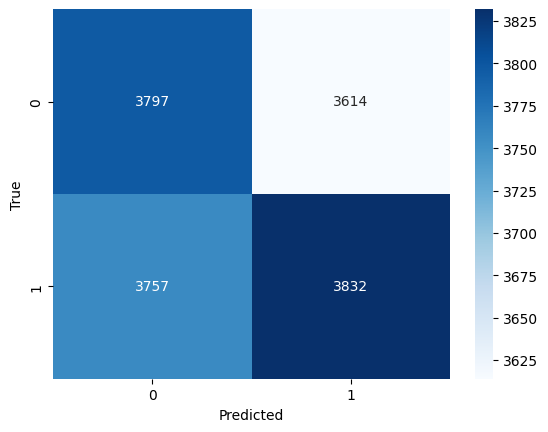

In [323]:
cm = confusion_matrix(y_test_rnn,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

Guardamos el modelo y generamos la submission para kaggle.

In [324]:
pickle.dump(rnn_model, open('rnn_grupo29.pickle', 'wb'))

In [ ]:
X_submission_rnn = encoded_test_truncado.tolist()

In [326]:
y_pred_test_rnn = rnn_model.predict(X_submission_rnn)

269/269 [==============================] - 16s 60ms/step


In [327]:
y_pred_test_rnn_binario = np.where(y_pred_test_rnn > 0.5, 1, 0)
y_pred_test_rnn_binario

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [328]:
label_map = {0: 'negativo', 1: 'positivo'}

y_pred_test_rnn_binario = pd.Series(y_pred_test_rnn_binario.flatten()).map(label_map).values
y_pred_test_rnn_binario

array(['negativo', 'positivo', 'negativo', ..., 'negativo', 'positivo',
       'negativo'], dtype=object)

In [329]:
df_submission_rnn = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_rnn_binario})
df_submission_rnn.to_csv('rnn01.csv', index=False)

## Ensamble

### Creacion del voting classifier

Vamos a crear un ensamble de tipo Voting Classifier, que consiste en obtener la predicción de varios modelos, y quedarnos con la predicción que más votos tenga.

In [408]:
def score(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, error_score='raise')
    return scores

Los modelos clasificadores que se utilizarán para el ensamble serán Random Forest, XGBoost y Naive Bayes que ya fueron entrenados en este notebook.

In [409]:
models = {
    'random_forest': rf_model,
    'xgboost': xgb_model,
    'bayes_naive': NB_model,
}

Creamos el Voting Classifier con los modelos elegidos, lo entrenamos con los datos y obtenemos las predicciones.

In [436]:
#Creo ensemble de Votación
voting = VotingClassifier(estimators = [('random_forest', rf_model), ('xgboost', xgb_model), ('bayes_naive', NB_model)], voting = 'hard', n_jobs=-1)

#Entreno el ensemble
modelo_voting = voting.fit(x_train, y_train_mapped)

#Obtengo predicciones
y_pred = voting.predict(x_test)

Evaluamos la performance de cada uno de los modelos por separado:

In [457]:
resultado, nombres = list(), list()
for nombre, model in models.items():
	scores = score(model, x_train, y_train_mapped)
	resultado.append(scores)
	nombres.append(nombre)
	print('%s %.3f' % (nombre, mean(scores)))

random_forest 0.718
xgboost 0.819
bayes_naive 0.844


Ahora evaluamos la performance del Voting Classifier:

In [458]:
score_voting = score(voting, x_train, y_train_mapped)

In [459]:
score_voting

array([0.8245348 , 0.83118309, 0.83342421, 0.83149134, 0.83654629,
       0.82985487, 0.83642268, 0.83005561, 0.83143913, 0.83215452])

Obtenemos la media de los scores

In [460]:
print('Voting Classifier:', mean(score_voting))

Voting Classifier: 0.8317106540450812


In [461]:
resultado.append(score_voting)
nombres.append('voting')

### Métricas

Calculamos las métricas para ver el desempeño del ensamble de modelos.

In [440]:
accuracy = accuracy_score(y_test_mapped, y_pred)
recall = recall_score(y_test_mapped, y_pred)
f1 = f1_score(y_test_mapped, y_pred)
precision = precision_score(y_test_mapped, y_pred)

print("Accuracy: "  + str(accuracy))
print("Recall: "    + str(recall))
print("Precision: " + str(precision))
print("f1 score: "  + str(f1))

Accuracy: 0.8304666666666667
Recall: 0.8811437607062854
Precision: 0.8029538904899135
f1 score: 0.8402337123829867


El reporte de clasificación:

In [442]:
print(classification_report(y_test_mapped,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      7411
           1       0.80      0.88      0.84      7589

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



Y la matriz de confusión:

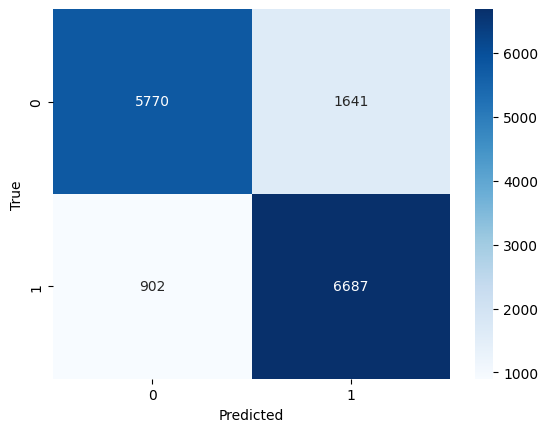

In [444]:
cm = confusion_matrix(y_test_mapped,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Ahora podemos comparar la performance de los modelos por separado con la del ensamble de dichos modelos, como se puede ver en el siguiente gráfico:

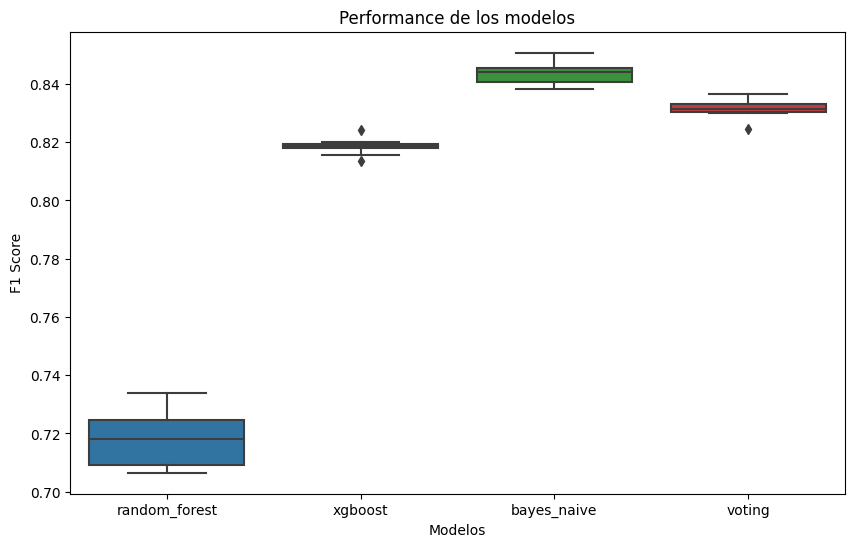

In [463]:
plt.figure(figsize=(10,6))
sns.boxplot(resultado).set(xticklabels=nombres, title='Performance de los modelos', xlabel='Modelos', ylabel='F1 Score')
plt.show()

La predicción final se basa en la mayoría de los votos de los modelos base, por lo que obtenemos un modelo que en general posee mayor precision que los modelos individuales. 

Esto se debe a que puede aprovechar las fortalezas de cada modelo individual y reducir el impacto de las debilidades de cada uno.

En este caso, al evaluar la performance de los modelos por separado, el bayes naive tiene un mejor desempeño que los otros dos modelos base (xgboost y random forest). 

Al ensamblar los modelos en un ensamble híbrido de tipo voting classifier obtenemos un modelo que performa de mejor manera que el random forest y que el xgboost por separado aunque es apenas peor que el bayes naive.

### Submission

Guardamos el ensamble en un archivo .pickle y generamos la submission para kaggle.

In [446]:
pickle.dump(modelo_voting, open('voting_grupo29.pickle', 'wb'))

In [448]:
X_submission_voting = test_fid
y_pred_test_voting = modelo_voting.predict(X_submission_voting)

In [449]:
label_map = {0: 'negativo', 1: 'positivo'}
y_pred_test_voting = pd.Series(y_pred_test_voting).map(label_map)

In [450]:
df_submission_voting = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_voting})
df_submission_voting.to_csv('voting00.csv', index=False)